# Instance of Training Pipeline

We explore 1 dataset over 1 fold for the OAK model

### Set up

In [459]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import argparse
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from oak.model_utils import oak_model, save_model
from oak.utils import get_model_sufficient_statistics, get_prediction_component
from scipy import io
from sklearn.model_selection import KFold
from pathlib import Path

In [460]:
data_path_prefix = os.path.join(
    Path(os.getcwd()).absolute(), f"data/"
)
data_path_prefix

'c:\\Users\\User\\Documents\\orthogonal-additive-gaussian-processes\\data/'

### Pick and configure dataset

In [461]:
# data from repo: https://github.com/duvenaud/additive-gps/blob/master/data/regression/
# this script is for experiments in Sec 5.1 for regression problems in the Lu et al. paper

# plotting preferences
matplotlib.rcParams.update({"font.size": 25})
np.set_printoptions(formatter={"float": lambda x: "{0:0.5f}".format(x)})



# dataset configuration
dataset_name = "synthetic_behaviour_type6"
filename = data_path_prefix + dataset_name + ".mat"
print(filename)
covariate_names = [
    "x1",
    "x2",
    "x3",
    "x4",
    "x5",
    "x6",
    "x7",
    "x8",
    "x9",
    "x10",
]

# save results to outputs folder
if not os.path.exists(f".scratch.my_outputs/{dataset_name}/"):
    os.mkdir(f".scratch.my_outputs/{dataset_name}/")

np.random.seed(42)
tf.random.set_seed(42)

print(f"dataset: {dataset_name}\n")

c:\Users\User\Documents\orthogonal-additive-gaussian-processes\data/synthetic_behaviour_type6.mat
dataset: synthetic_behaviour_type6



### Data Loading

In [462]:
# load data
d = io.loadmat(filename)
if dataset_name == "new":
    # general placeholder for new datasets
    X, y = d["X"], d["y"]
else:
    # for synthetic datasets, the first column is the response y
    X, y = d["X"][:, 1:], d["X"][:, :1]

# shuffle data
idx = np.random.permutation(range(X.shape[0]))

# k fold setting if we were doing multiple folds
k = 5
X = X[idx, :]
y = y[idx]
kf = KFold(n_splits=k)

# we only take the first fold for this example for speed
fold = 0
for train_index, test_index in kf.split(X):
    if fold == 0:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    fold += 1
  


### Training

In [463]:
# fitting the OAK model

oak = oak_model(max_interaction_depth=X.shape[1]) # max depth is set to the number of features
oak.fit(X_train, y_train)

indices of binary feature  []
indices of continuous feature  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
indices of categorical feature  []
[None, None, None, None, None, None, None, None, None, None]
Using sparsity prior


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1000
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1000
GPR.kernel.kernels[2].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,4.32377
GPR.kernel.kernels[3].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,6.0112
GPR.kernel.kernels[4].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,5.83692
GPR.kernel.kernels[5].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,3.84955
GPR.kernel.kernels[6].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,6.15336
GPR.kernel.kernels[7].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,6.09755
GPR.kernel.kernels[8].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,5.99711
GPR.kernel.kernels[9].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,6.75254


Training took 32.7 seconds.


### Testing

In [464]:
# clipped to prevent extrapolation
x_max, x_min = X_train.max(0), X_train.min(0) 

# Prediction performance
y_pred = oak.predict(np.clip(X_test, x_min, x_max))

# Metrics: Residual Sum of Squares, Total Sum of Squares, R2, RMSE
rss = ((y_pred - y_test[:, 0]) ** 2).mean()
tss = ((y_test[:, 0] - y_test[:, 0].mean() * np.ones(y_test[:, 0].shape)) ** 2).mean()
r2 = 1 - rss / tss # explains how well model explains variance
rmse = np.sqrt(rss)
print(f"R2 = {r2:.5f}")
print(f"RMSE = {rmse:.5f}")



# calculate sobol for each term in the decomposition
print("Calculating Sobol indices:")
oak.get_sobol()

tuple_of_indices, normalised_sobols = (
    oak.tuple_of_indices,
    oak.normalised_sobols,
)
print(f"normalised_sobols = {normalised_sobols}")
print(f"tuple_of_indices = {tuple_of_indices}")




# Get predictions for each term (kernel) in prediction_list

# x_max, x_min = X_train.max(0), X_train.min(0) 
XT = oak._transform_x(np.clip(X_test, x_min, x_max)) # transformed
oak.alpha = get_model_sufficient_statistics(oak.m, get_L=False) # alpha is the sufficient statistics to make preds

# get the predicted y for all the kernel components
prediction_list = get_prediction_component(
    oak.m,
    oak.alpha,
    XT,
)

# predicted y for the constant kernel
constant_term = oak.alpha.numpy().sum() * oak.m.kernel.variances[0].numpy() # bias is sum of alpha * variance of constant kernel (first entry in kernel list)
print(f"constant_term = {constant_term}")
y_pred_component = np.ones(y_test.shape[0]) * constant_term # the bias is added to each prediction as a starting point


# now we add the predictive contributions of each kernel one by one
# we calculate RMSE, cumulative Sobol index at each kernel addition step
# order of addition: ranked by their Sobol (most important kernel first)
cumulative_sobol, rmse_component = [], []
order = np.argsort(normalised_sobols)[::-1]
for n in order:
    # add predictions of the terms one by one ranked by their Sobol index
    y_pred_component += prediction_list[n].numpy()
    y_pred_component_transformed = oak.scaler_y.inverse_transform(
        y_pred_component.reshape(-1, 1)
    ) #  the cumulative prediction is transformed back to the original scale
    error_component = np.sqrt(
        ((y_pred_component_transformed - y_test) ** 2).mean()
    )
    rmse_component.append(error_component)
    cumulative_sobol.append(normalised_sobols[n])
cumulative_sobol = np.cumsum(cumulative_sobol)

# sanity check that predictions by summing over the components is equal to the prediction of the OAK model
np.testing.assert_allclose(y_pred_component_transformed[:, 0], y_pred)


R2 = 0.99712
RMSE = 0.00135
Calculating Sobol indices:
normalised_sobols = [-0.00000 -0.00000 0.11895 ... 0.00000 0.00000 0.00000]
tuple_of_indices = [[np.int64(0)], [np.int64(1)], [np.int64(2)], [np.int64(3)], [np.int64(4)], [np.int64(5)], [np.int64(6)], [np.int64(7)], [np.int64(8)], [np.int64(9)], [np.int64(0), np.int64(1)], [np.int64(0), np.int64(2)], [np.int64(0), np.int64(3)], [np.int64(0), np.int64(4)], [np.int64(0), np.int64(5)], [np.int64(0), np.int64(6)], [np.int64(0), np.int64(7)], [np.int64(0), np.int64(8)], [np.int64(0), np.int64(9)], [np.int64(1), np.int64(2)], [np.int64(1), np.int64(3)], [np.int64(1), np.int64(4)], [np.int64(1), np.int64(5)], [np.int64(1), np.int64(6)], [np.int64(1), np.int64(7)], [np.int64(1), np.int64(8)], [np.int64(1), np.int64(9)], [np.int64(2), np.int64(3)], [np.int64(2), np.int64(4)], [np.int64(2), np.int64(5)], [np.int64(2), np.int64(6)], [np.int64(2), np.int64(7)], [np.int64(2), np.int64(8)], [np.int64(2), np.int64(9)], [np.int64(3), np.int64(4)],

In [465]:
rmse_component

[np.float64(0.024266179649039377),
 np.float64(0.021506966276800207),
 np.float64(0.017902592061176743),
 np.float64(0.01576113471863604),
 np.float64(0.014599861138863926),
 np.float64(0.012281073054081737),
 np.float64(0.009571316193926276),
 np.float64(0.006424449270612154),
 np.float64(0.006414750425101782),
 np.float64(0.006541565204053213),
 np.float64(0.00636697903805532),
 np.float64(0.006332194399846089),
 np.float64(0.006153008108996062),
 np.float64(0.005890563888356133),
 np.float64(0.005971526297626892),
 np.float64(0.005830990926818068),
 np.float64(0.005194310120379326),
 np.float64(0.005028326232564073),
 np.float64(0.005034132132450225),
 np.float64(0.004912210123601168),
 np.float64(0.005163524448220013),
 np.float64(0.005153797547956581),
 np.float64(0.005151664130993801),
 np.float64(0.0046117014750175775),
 np.float64(0.004261445370133907),
 np.float64(0.00403783600653355),
 np.float64(0.003965924899096183),
 np.float64(0.0037212889185841164),
 np.float64(0.0035318

In [466]:
cumulative_sobol

array([0.12200, 0.24304, 0.36318, ..., 1.00000, 1.00000, 1.00000])

### Getting OAK Model analysis out

In [467]:
import gpflow
gpflow.utilities.print_summary(oak.m, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1000
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1000
GPR.kernel.kernels[2].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,4.32377
GPR.kernel.kernels[3].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,6.0112
GPR.kernel.kernels[4].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,5.83692
GPR.kernel.kernels[5].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,3.84955
GPR.kernel.kernels[6].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,6.15336
GPR.kernel.kernels[7].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,6.09755
GPR.kernel.kernels[8].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,5.99711
GPR.kernel.kernels[9].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,6.75254


In [468]:
from oak.utils import extract_active_dims, get_list_representation, model_to_kernel_list

In [469]:
# 1. Extract the active dimensions for each kernel component.
#    This tells you which input dimensions (features) each kernel component is acting on.
active_dims = extract_active_dims(oak.m)
print("\nActive dimensions for each kernel component:")
for i, dims in enumerate(active_dims):
    print(f"Kernel component {i}: {dims}")

# 2. Get the additive kernel representation using get_list_representation.
#    This function decomposes the overall OAK kernel into its additive parts (including the constant term)
#    and returns a list of the selected dimensions for each component.
selected_dims, whatthis = get_list_representation(oak.m.kernel, num_dims=oak.num_dims)
print("\nAdditive kernel representation (selected dimensions):")
for i, dims in enumerate(selected_dims):
    print(f"Component {i}: {dims}")

# 3. Retrieve the exact list of kernel objects used in the model using model_to_kernel_list.
#    This will give you the actual kernel instances (including the constant kernel) corresponding to each component.
kernel_list = model_to_kernel_list(oak.m, selected_dims)
print("\nExact kernel list from the model:")
for i, kernel in enumerate(kernel_list):
    print(f"Kernel {i}: {kernel}")





Active dimensions for each kernel component:
Kernel component 0: [np.int64(0)]
Kernel component 1: [np.int64(1)]
Kernel component 2: [np.int64(2)]
Kernel component 3: [np.int64(3)]
Kernel component 4: [np.int64(4)]
Kernel component 5: [np.int64(5)]
Kernel component 6: [np.int64(6)]
Kernel component 7: [np.int64(7)]
Kernel component 8: [np.int64(8)]

Additive kernel representation (selected dimensions):
Component 0: []
Component 1: [np.int64(0)]
Component 2: [np.int64(1)]
Component 3: [np.int64(2)]
Component 4: [np.int64(3)]
Component 5: [np.int64(4)]
Component 6: [np.int64(5)]
Component 7: [np.int64(6)]
Component 8: [np.int64(7)]
Component 9: [np.int64(8)]
Component 10: [np.int64(9)]
Component 11: [np.int64(0), np.int64(1)]
Component 12: [np.int64(0), np.int64(2)]
Component 13: [np.int64(0), np.int64(3)]
Component 14: [np.int64(0), np.int64(4)]
Component 15: [np.int64(0), np.int64(5)]
Component 16: [np.int64(0), np.int64(6)]
Component 17: [np.int64(0), np.int64(7)]
Component 18: [np.i

In [470]:
# whatthis

In [471]:
# Get the product kernel representing the non-constant (signal) part.
prod_kernel = oak.m.kernel.kernels

# Hyperparameters for the kernel corresponding to xi (ith factor)
params = {}
for i in range(len(prod_kernel)):
    params[f'lengthscale_x{i}'] = prod_kernel[i].base_kernel.lengthscales.numpy()
    params[f'variance_x{i}'] = prod_kernel[i].base_kernel.variance.numpy()
    print(f"x{i} - Lengthscale:", params[f'lengthscale_x{i}'], "Variance:", params[f'variance_x{i}'])

x0 - Lengthscale: 999.9999941937884 Variance: [1.00000]
x1 - Lengthscale: 1000.0 Variance: [1.00000]
x2 - Lengthscale: 4.323768456323668 Variance: [1.00000]
x3 - Lengthscale: 6.011199806886897 Variance: [1.00000]
x4 - Lengthscale: 5.836922616699536 Variance: [1.00000]
x5 - Lengthscale: 3.849545532018703 Variance: [1.00000]
x6 - Lengthscale: 6.153357877693446 Variance: [1.00000]
x7 - Lengthscale: 6.0975451296248595 Variance: [1.00000]
x8 - Lengthscale: 5.997109770708434 Variance: [1.00000]
x9 - Lengthscale: 6.752538909252628 Variance: [1.00000]


In [472]:
# negative log likelihood
nll = (
    -oak.m.predict_log_density(
        (
            oak._transform_x(np.clip(X_test, x_min, x_max)),
            oak.scaler_y.transform(y_test),
        )
    )
    .numpy()
    .mean()
)

print(f"RBF test nll = {np.round(nll, 4)}")

RBF test nll = -1.5061


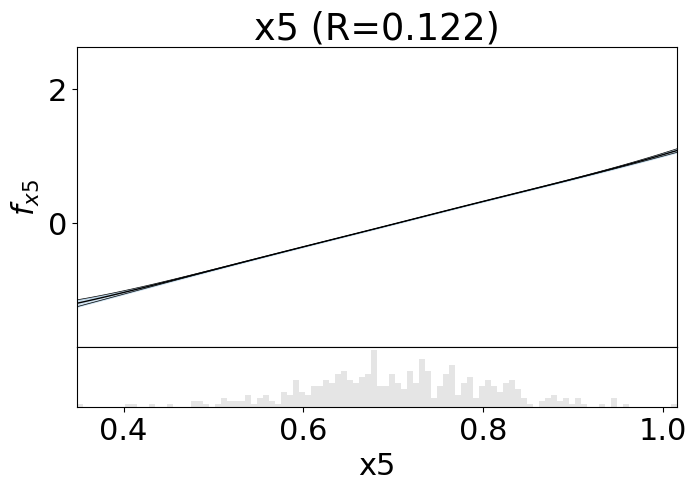

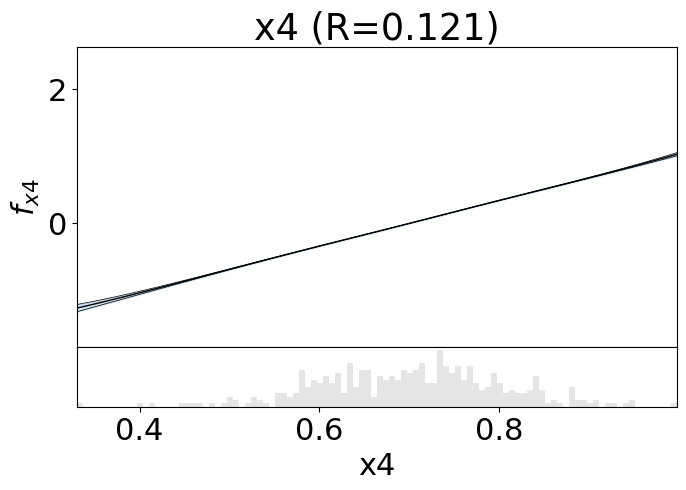

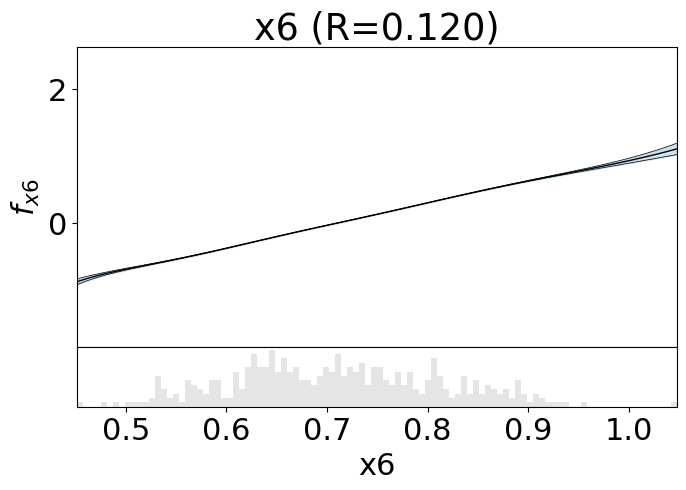

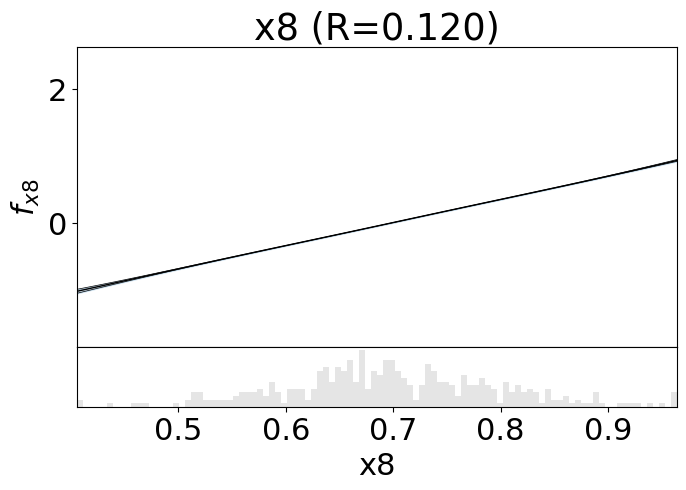

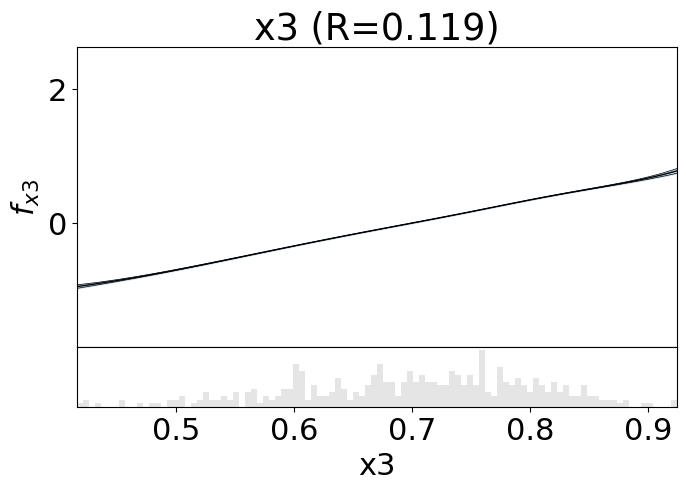

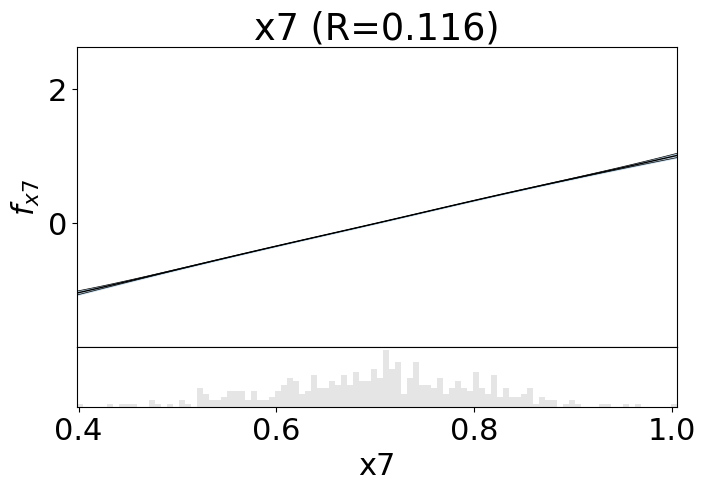

In [473]:
# plot decomposition of the functions, ranked by their (normalised) Sobol index, 
# which are in the bracket in ther plot title
oak.plot(
    top_n=6,
    semilogy=False,
    X_columns=covariate_names,
)

<Figure size 800x400 with 0 Axes>

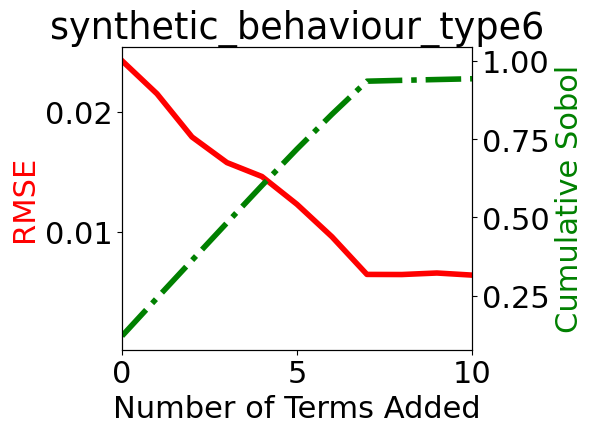

In [474]:
# generate plots in Fig. 5 (\ref{fig:sobol_plots}) of paper
plt.figure(figsize=(8, 4))
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(np.arange(len(order)), rmse_component, "r", linewidth=4)
ax2.plot(np.arange(len(order)), cumulative_sobol, "-.g", linewidth=4)

ax1.set_xlabel("Number of Terms Added")
ax1.set_ylabel("RMSE", color="r")
ax2.set_ylabel("Cumulative Sobol", color="g")

plt.title(dataset_name)
plt.xlim([0,10])
plt.tight_layout()

[0.93484 0.06280 0.00234 0.00003 0.00000 0.00000 0.00000 0.00000 0.00000
 0.00000]


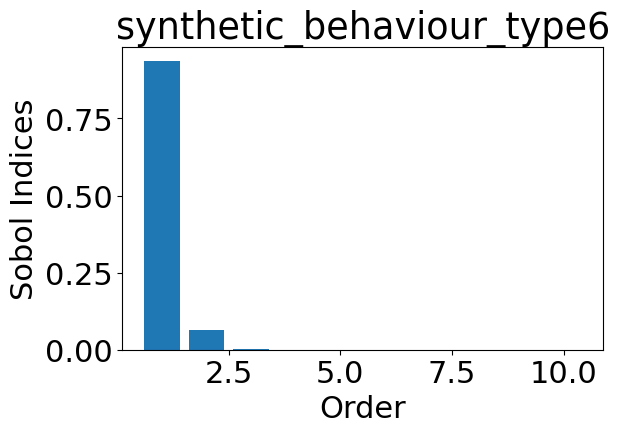

In [475]:
# aggregate sobol per order of interactions
sobol_order = np.zeros(len(tuple_of_indices[-1]))
for i in range(len(tuple_of_indices)):
    sobol_order[len(tuple_of_indices[i]) - 1] += normalised_sobols[i]


# generate plot similar to Figure 4 (\ref{fig:sobol}) in the paper for one fold. 
# Figure 4 (\ref{fig:sobol}) in the paper takes the mean and adds standard deviation for 5 folds. 
fig, ax = plt.subplots()
for j in range(len(sobol_order)):
    plt.bar(j+1, np.array([sobol_order[j] ]).mean(),\
           yerr = np.array([sobol_order[j] ]).std(),\
           color = 'C0', ecolor = 'k')

plt.xlabel('Order')
plt.ylabel('Sobol Indices')
plt.title(dataset_name)
plt.tight_layout()

print(sobol_order)